In [1]:
import torch
import os

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [3]:
data_dir = "../data/fruits 360/fruits-360_dataset/fruits-360"
print("Folder contains:", os.listdir(data_dir))

Folder contains: ['LICENSE', 'papers', 'readme.md', 'Test', 'test-multiple_fruits', 'Training']


In [4]:
labels = os.listdir(data_dir + "/Training")
print("Labels count:", len(labels))
print("Labels:\n", labels)

Labels count: 131
Labels:
 ['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Ma

In [5]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [6]:
T = transforms.Compose([transforms.ToTensor()])

In [9]:
dataset = ImageFolder(data_dir + "/Training", transform=T)
print("Training dataset size:", len(dataset))
test_dataset = ImageFolder(data_dir + "/Test", transform=T)
print("Test dataset size:", len(test_dataset))

Training dataset size: 67692
Test dataset size: 22688


In [10]:
import matplotlib.pyplot as plt

Label: Apple Golden 1 at 2 dim: torch.Size([3, 100, 100])


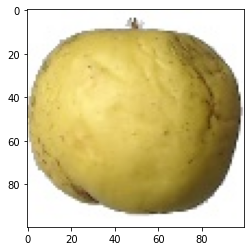

In [27]:
def view_image(img, label):
    print("Label:", dataset.classes[label], "at", label, "dim:", img.shape)
    plt.imshow(img.permute(1, 2, 0))
    return None

img, label = dataset[1099]
view_image(img, label)

In [12]:
from torch.utils.data import random_split

In [13]:
small_data = len(dataset) // 10
other_data = len(dataset) - small_data

In [14]:
data_other, data = random_split(dataset, [other_data, small_data])
len(data_other), len(data)

(60923, 6769)

In [15]:
val_size = len(data) // 10
train_size = len(data) - val_size
train_data, val_data = random_split(data, [train_size, val_size])
len(train_data), len(val_data), len(test_dataset)

(6093, 676, 22688)

In [16]:
from torch.utils.data import DataLoader

In [39]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True, num_workers=6, drop_last=True)
val_loader = DataLoader(val_data, batch_size=64, pin_memory=True, num_workers=6, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, pin_memory=True, num_workers=6)

In [40]:
from torchvision.utils import make_grid

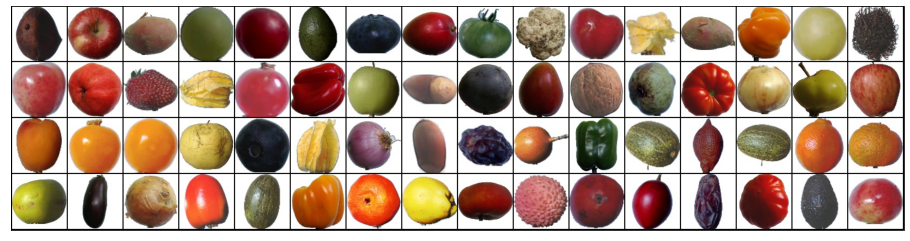

In [41]:
for img, label in train_loader:
    fig, ax = plt.subplots(figsize=(16, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(img, nrow=16).permute(1, 2, 0))
    break

In [42]:
import torch.nn as nn

In [43]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # applying same padding
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        # batch norm, relu and maxpool just after conv1 layer op-> size = ((100 - 3 + (2 + 1)) / 1) + 1 and whole //2 = 50
        self.batchnorm_1 = nn.BatchNorm2d(8) # takes the depth size
        self.relu = nn.ReLU()
        self.maxpool2d = nn.MaxPool2d(kernel_size=2)
        # l - 2 same padding size after 2nd -> 25
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
        # batch norm on depth: 32 
        self.batchnorm_2 = nn.BatchNorm2d(32)
        # fully connected layers -  25 * 25 * 32
        self.fc1 = nn.Linear(25 * 25 * 32, 600)
        self.dropout = nn.Dropout(p=0.25)
        self.fc2 = nn.Linear(600, 131)
    
    def forward(self, x):
        z1 = self.conv1(x)
        a1 = self.maxpool2d(self.relu(self.batchnorm_1(z1)))
        z2 = self.conv2(a1)
        a2 = self.maxpool2d(self.relu(self.batchnorm_2(z2)))
        # flattenning outputs (25, 25, 32), depth size=32, and pixel size=25
        a2 = a2.view(-1, 25 * 25 * 32)  
        # forward layer
        z3 = self.fc1(a2)
        a3 = self.dropout(self.relu(z3))
        z4 = self.fc2(a3)
        return z4

In [44]:
model = CNN()
Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [45]:
# testing
model = model.to(device)

for x, y in train_loader:
    x = x.to(device)
    y = y.to(device)
    print("Input(x) shape:", x.shape)
    print("Labels(y) shape:", y.shape)
    yhat = model(x)
    print("yhat shape:", yhat.shape)
    _, predicted = torch.max(yhat, 1)
    print("predicted shape:", predicted.shape)
    print("tensors:")
    print(predicted)
    break

Input(x) shape: torch.Size([64, 3, 100, 100])
Labels(y) shape: torch.Size([64])
yhat shape: torch.Size([64, 131])
predicted shape: torch.Size([64])
tensors:
tensor([101,  19,  41,  64,  85,  38,  39,  38,  38,  85,  85,  20,  19,  41,
         41,  78,  44,  41,  38,  41,  38,  44,  85,  85,  76,  38,  38,  38,
         41,  85,  44,  41,  41,  44,  44,  19,  38,  18,  53,  38,  38,  66,
         44,  38,  41,  33, 100,  78,  77,  38,  38,  41,  19,  38,  41,  38,
         41,  38,  41,  38, 106,  38,  38,  38], device='cuda:0')


In [80]:
def evaluate(yh, y):
    # print(yh.shape, y.shape)
    _, p = torch.max(yh, 1)
    return (p == y).sum().item() / len(p)

In [81]:
def train_model(model, Loss, optimizer, train_load, val_load, epochs=5, verbose=True):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
    model = model.to(device)
    
    for epoch in range(epochs):
        correct = 0.0
        iterations = 0
        iter_loss = 0.0
        model.train()
        
        for x, y in train_load:
            x = x.to(device)
            y = y.to(device)
            
            yh = model(x)
            loss = Loss(yh, y)
            iter_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            correct += evaluate(yh, y)
            iterations += 1
            
        train_acc.append(100 * correct)
        train_loss.append(iter_loss / iterations)
        
        # testing
        test_loss = 0.0
        test_correct = 0.0
        iterations = 0
        
        model.eval()
        
        for x, y in val_load:
            x = x.to(device)
            y = y.to(device)
            
            yh = model(x)
            loss = Loss(yh, y)
            test_loss += loss.item()
            iterations += 1
            test_correct += evaluate(yh, y)
        
        val_acc.append(100 * test_correct)
        val_loss.append(test_loss / iterations)
        
        print("Epoch: {}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Valid Loss: {:.3f}, Valid Accuracy: {:.3f}".format(
        epoch + 1, train_loss[-1], train_acc[-1], val_loss[-1], val_acc[-1]))
    
    return model, train_acc, train_loss, val_acc, val_loss

In [82]:
model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
Loss = nn.CrossEntropyLoss()

In [ ]:
model, train_acc, train_loss, val_acc, val_loss = train_model(model, Loss, optimizer, train_load=train_loader,
                                                              val_load=val_loader)